# SentimentArcs Simplified Notebook

Created:

* 28 Oct 2022
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

# Review VM Specs

In [1]:
# Make sure your Linux VM is connected to a GPU

!nvidia-smi

Mon Oct 28 17:17:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Node GPU Count/Type

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c2bc3385-d1cd-9374-6002-c0fe8c66b183)


In [3]:
# Memory

!free -h --si | awk  '/Mem:/{print $2}'

12G


In [4]:
# GPU log information

# !nvidia-smi -q

In [5]:
# Check how many CPU cores available for parallization

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.164
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [6]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.32
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

# Setup

## Install Libraries

In [7]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [8]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [9]:
from google.colab import files

In [10]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
import os

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

## Configure Settings

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [12]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [13]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [14]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [15]:
def save_plot2png(file_suffix='_plot.png', nodate=True):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
        out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [16]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False)
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

# Get Clean Text

## Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [17]:
# Upload Plain Text File
novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    novel_name_str = fn

# Extract from Dict and decode binary into char string
TEXT_ENCODING = 'utf-8'  # Define the encoding format
novel_raw_str = uploaded[novel_name_str].decode(TEXT_ENCODING)


Saving book_great-gatsby_plain.txt to book_great-gatsby_plain.txt
User uploaded file "book_great-gatsby_plain.txt" with length 286442 bytes


In [18]:
# Verify

verify_novel(novel_raw_str)

Novel Name: book_great-gatsby_plain.txt
  Char Len: 276892

Beginning:

                               Once again
                                  to
                                 Zelda


  Then wear the gold hat, if that will move her;
  If you can bounce high, bounce for her too,
  Till she cry “Lover, gold-hatted, high-bouncing lover,
  I must have you!”

  Thomas Parke d’Invilliers


                                  I

In my younger and more vulnerable years my father gave me some advice
that I’ve been turning over in my mind ever since.

“



------------------------------------
Ending:

 hardly fail to grasp it. He
did not know that it was already behind him, somewhere back in that
vast obscurity beyond the city, where the dark fields of the republic
rolled on under the night.

Gatsby believed in the green light, the orgastic future that year by
year recedes before us. It eluded us then, but that’s no
matter—tomorrow we will run faster, stretch out our arms further … And
one

## Clean Text

In [19]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=a64f062a76b80e26083c47ed82f531a937c625061568ac66eb9a96c8186c56b3
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [20]:
!pip install unidecode  # clean-text dependency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.3 MB/s eta 0:00:00


In [21]:
from cleantext import clean

In [22]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d\'invilliers i in my younger and more vulnerable years my father gave me some advice that i\'ve been turning over in my mind ever since. "whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had." he didn\'t say any more, but we\'ve always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that. in consequence, i\'m inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college i was unjustly accused of being a politician, bec

In [23]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_great-gatsby_plain.txt
  Char Len: 268671

Beginning:

 once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d'invilliers i in my younger and more vulnerable years my father gave me some advice that i've been turning over in my mind ever since. "whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven't had the advantages that you've had." he didn't say an



------------------------------------
Ending:

 he could hardly fail to grasp it. he did not know that it was already behind him, somewhere back in that vast obscurity beyond the city, where the dark fields of the republic rolled on under the night. gatsby believed in the green light, the orgastic future that year by year recedes before us. it eluded us then, but that's no matter--tomorrow we will run faster, stretch out

## Trim Text

In [24]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [25]:
!pip install pysbd  # Python Sentence Boundry Detection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.1 MB/s eta 0:00:00


In [26]:
import pysbd

In [27]:
# FIX: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [28]:
%%time

# NOTE: 1m05s

# Split Novel into Segments (~Sentences)
seg = pysbd.Segmenter(language="en", clean=False)
novel_segments_ls = seg.segment(novel_trim_str)

CPU times: user 40.9 s, sys: 169 ms, total: 41.1 s
Wall time: 56.3 s


In [29]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [30]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_great-gatsby_plain.txt
  Char Len: 1357

Beginning:

 ['once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d\'invilliers i in my younger and more vulnerable years my father gave me some advice that i\'ve been turning over in my mind ever since.', '"whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had." he didn\'t say any more, but we\'ve always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that.', "in consequence, i'm inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores.", 'the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so

In [31]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_great-gatsby_plain_segments.txt

STEP 3. Downloading permanent copy of textfile: book_great-gatsby_plain_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
sentiment_df

pandas.core.frame.DataFrame

In [33]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

1356

,line_no,line
0,0,"once again to zelda then wear the gold hat, if..."
1,1,"""whenever you feel like criticizing anyone,"" h..."
2,2,"in consequence, i'm inclined to reserve all ju..."
3,3,the abnormal mind is quick to detect and attac...
4,4,most of the confidences were unsought--frequen...


# Compute Sentiment

## Option (1): Symbolic: Lexicons

### VADER

In [34]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.4 MB/s eta 0:00:00


In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [36]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [37]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['sentiment'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,sentiment
0,0,"once again to zelda then wear the gold hat, if...",0.5572
1,1,"""whenever you feel like criticizing anyone,"" h...",0.7265
2,2,"in consequence, i'm inclined to reserve all ju...",-0.2732
3,3,the abnormal mind is quick to detect and attac...,-0.2960
4,4,most of the confidences were unsought--frequen...,0.3797


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'VADER Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_great-gatsby_plain_vader_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_great-gatsby_plain_vader_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

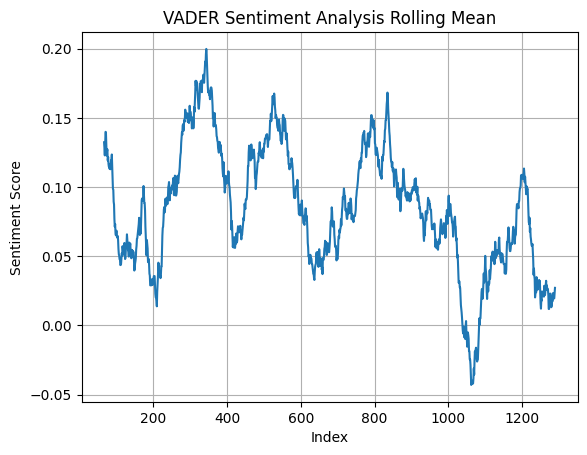

In [38]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

_ = vader_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("VADER Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_vader_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [39]:
# Save VADER Model Sentiment Time Series

save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_great-gatsby_plain_vader_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_great-gatsby_plain_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **TextBlob**

In [40]:
from textblob import TextBlob

In [41]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [42]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [43]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['sentiment'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,sentiment
0,0,"once again to zelda then wear the gold hat, if...",0.050000
1,1,"""whenever you feel like criticizing anyone,"" h...",0.500000
2,2,"in consequence, i'm inclined to reserve all ju...",0.085000
3,3,the abnormal mind is quick to detect and attac...,0.016667
4,4,most of the confidences were unsought--frequen...,-0.050744


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'TextBlob Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_great-gatsby_plain_textblob_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_great-gatsby_plain_textblob_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

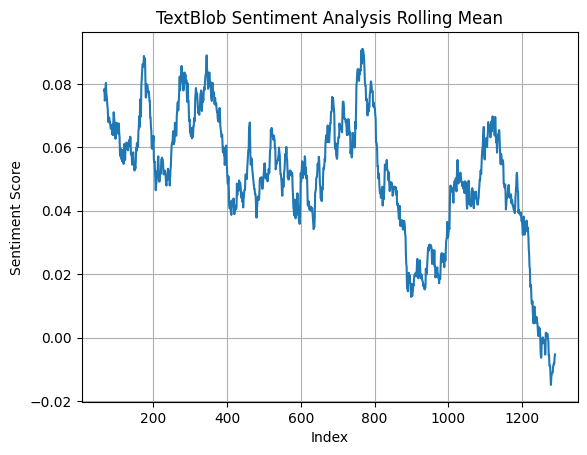

In [44]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

# Create a new figure
plt.figure()

_ = textblob_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("TextBlob Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_textblob_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [45]:
# Save TextBlob Model Sentiment Time Series

save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True)

NameError: name 'sentiment_textblob_df' is not defined

### SyuzhetR (4)

* SyzuhetR: https://cran.r-project.org/web/packages/readtext/vignettes/readtext_vignette.html
* http://rstudio-pubs-static.s3.amazonaws.com/283881_efbb666d653a4eb3b0c5e5672e3446c6.html

* SentimentR: https://github.com/trinker/sentimentr

* JupyterLab w/Py OR R: https://www.youtube.com/watch?v=Q35WIqZoUF4

In [ ]:
%load_ext rpy2.ipython

In [ ]:
# Load Python libraries to exchange data with R Program Space and read R Datafiles

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [ ]:
%R getwd()

In [ ]:
%R list.files()

In [ ]:
%%time
%%capture
%%R

# Install Syuzhet.R, Sentiment.R and Utility Libraries

# NOTE: 56s 17:30EST on 27Oct2022 - Colab Pro

install.packages(c('syuzhet', 'sentimentr', 'tidyverse', 'lexicon'))

library(syuzhet)
library(sentimentr)
library(tidyverse)
library(lexicon)

In [ ]:
%R sessionInfo()

In [ ]:
sentiment_df.head()

In [ ]:
%%time

# Compute Sentiments from all 4 Syuzhet Models

# NOTE:  3m57s 17:40EST on 27Oct2022 Colab Pro (The Idiot)
#        3m55s 18:02EST on 27Oct2022 Colab Pro (The Idiot)
#        4m10s 23:14EST on 27Oct2022 Colab Pro (The Idiot)

syuzhet = importr('syuzhet')

# Create new SyuzhetR DataFrame to save results
syuzhet_df = sentiment_df[['line_no', 'line']].copy(deep=True)

print('[1/4] Processing syuzhetr_syuzhet')
syuzhet_df['syuzhetr_syuzhet'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='syuzhet')
print('[2/4] Processing syuzhetr_bing')
syuzhet_df['syuzhetr_bing'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='bing')
print('[3/4] Processing syuzhetr_afinn')
syuzhet_df['syuzhetr_afinn'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='afinn')
print('[4/4] Processing syuzhetr_nrc')
syuzhet_df['syuzhetr_nrc'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='nrc')

syuzhet_df.head()

In [ ]:
# Generate the plot properly
win_per = 0.1
win_size = int(win_per * syuzhet_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean sentiment
syuzhet_model_ls = ['syuzhetr_syuzhet', 'syuzhetr_bing', 'syuzhetr_afinn', 'syuzhetr_nrc']
_ = syuzhet_df[syuzhet_model_ls].rolling(win_size, center=True).mean().plot(figsize=(12,6), grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("Syuzhet Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_syzhet_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()


In [ ]:
# Save SyuzhetR Models' Sentiment Time Series

save_df2csv_and_download(syuzhet_df, '_syuzhetr_sentiment.csv', nodate=True)

### SentimentR (8)

Call function in external get_sentimentr.R from within Python Loop

* https://medium.com/analytics-vidhya/calling-r-from-python-magic-of-rpy2-d8cbbf991571

* https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

In [ ]:
%%file get_sentimentr.R

library(sentimentr)
library(lexicon)

get_sentimentr_values <- function(s_v) {

  print('[1/8] Processing sentimentr_jockersrinker')
  sentimentr_jockersrinker <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers_rinker,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[2/8] Processing sentimentr_jockers')
  sentimentr_jockers <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[3/8] Processing sentimentr_huliu')
  sentimentr_huliu <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_huliu,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[4/8] Processing sentimentr_nrc')
  sentimentr_nrc <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_nrc,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[5/8] Processing sentimentr_senticnet')
  sentimentr_senticnet <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_senticnet,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[6/8] Processing sentimentr_sentiword')
  sentimentr_sentiword <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_sentiword,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[7/8] Processing sentimentr_loughran_mcdonald')
  sentimentr_loughran_mcdonald <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_loughran_mcdonald,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[8/8] Processing sentimentr_socal_google')
  sentimentr_socal_google <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_socal_google,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  anovel_sentimentr_df <- data.frame(# 'text_clean' = s_v,
                                'sentimentr_jockersrinker' = sentimentr_jockersrinker$sentiment,
                                'sentimentr_jockers' = sentimentr_jockers$sentiment,
                                'sentimentr_huliu' = sentimentr_huliu$sentiment,
                                'sentimentr_nrc' = sentimentr_nrc$sentiment,
                                'sentimentr_senticnet' = sentimentr_senticnet$sentiment,
                                'sentimentr_sentiword' = sentimentr_sentiword$sentiment,
                                'sentimentr_loughran_mcdonald' = sentimentr_loughran_mcdonald$sentiment,
                                'sentimentr_socal_google' = sentimentr_socal_google$sentiment
                                )
  return(anovel_sentimentr_df)

}

In [ ]:
# Verify the *.R file above was written correctly

# !cat get_sentimentr.R

In [ ]:
# Setup python robject with external library::function()
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

# import rpy2.robjects as robjects

# Defining the R script and loading the instance in Python
# from rpy2.robjects import pandas2ri
r = robjects.r

# Loading the function we have defined in R.
r['source']('get_sentimentr.R')

# Reading and processing data
get_sentimentr_function_r = robjects.globalenv['get_sentimentr_values']

In [ ]:
%%time

# NOTE:   2m40s  @17:48EST on 27Oct2022 Colab Pro (The Idiot)
#         2m42s  @18:06EST on 27Oct2022 Colab Pro (The Idiot)
#         2m37s  @23:20EST on 27Oct2022 Colab Pro (The Idiot)

# Call external get_sentimentr::get_sentimentr_values with Python loop over all novels

line_ls = sentiment_df['line'].to_list()

# Convert Python List of Strings to a R vector of characters
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html
sentence_v = robjects.StrVector(line_ls)
sentiment_df_r = get_sentimentr_function_r(sentence_v)

# Convert rpy2.robjects.vectors.DataFrame to pandas.core.frame.DataFrame
# https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
print(f'type(sentiment_df_r): {type(sentiment_df_r)}')
temp_df = pd.DataFrame.from_dict({ key : np.asarray(sentiment_df_r.rx2(key)) for key in sentiment_df_r.names })
print(f'type(temp_df): {type(temp_df)}')

# Create new SentimentR DataFrame to save results
# sentimentr_df = sentiment_df[['line_no', 'line']].copy(deep=True)
sentimentr_df = pd.DataFrame()

# This works for Novels New Corpus Texts
sentimentr_df['sentimentr_jockersrinker'] = temp_df['sentimentr_jockersrinker']
sentimentr_df['sentimentr_jockers'] = temp_df['sentimentr_jockers']
sentimentr_df['sentimentr_huliu'] = temp_df['sentimentr_huliu']
sentimentr_df['sentimentr_nrc'] = temp_df['sentimentr_nrc']
sentimentr_df['sentimentr_senticnet'] = temp_df['sentimentr_senticnet']
sentimentr_df['sentimentr_sentiword'] = temp_df['sentimentr_sentiword']
sentimentr_df['sentimentr_loughran_mcdonald'] = temp_df['sentimentr_loughran_mcdonald']
sentimentr_df['sentimentr_socal_google'] = temp_df['sentimentr_socal_google']

sentimentr_df.head()

In [ ]:
# prompt: for sentiment_df, insert 'line_no" as the first column that assigns sequentially increasing integers from 0 upward, drop the index

# Assuming sentiment_df is your DataFrame
sentimentr_df = sentimentr_df.reset_index(drop=True)
sentimentr_df.insert(0, 'line_no', range(0, len(sentimentr_df)))
sentimentr_df.head()

In [ ]:
sentimentr_df.columns.to_list()

In [ ]:
# Generate the plot properly
win_per = 0.1
win_size = int(win_per * sentimentr_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean sentiment
sentimentr_model_ls = [
    'sentimentr_jockersrinker',
    'sentimentr_jockers',
    'sentimentr_huliu',
    'sentimentr_nrc',
    'sentimentr_senticnet',
    'sentimentr_sentiword',
    'sentimentr_loughran_mcdonald',
    'sentimentr_socal_google']
_ = sentimentr_df[sentimentr_model_ls].rolling(win_size, center=True).mean().plot(figsize=(12,6), grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("SentimentR Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_sentimentr_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()


In [ ]:
# Save SyuzhetR Models' Sentiment Time Series

save_df2csv_and_download(sentimentr_df, '_sentimentr_sentiment.csv', nodate=True)

## Option (2): Statistical ML

* https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0

In [ ]:
# Example: Naive Bayes

# https://www.datacamp.com/tutorial/simplifying-sentiment-analysis-python

In [ ]:
# Example: SVM

# https://www.kaggle.com/code/bansodesandeep/sentiment-analysis-support-vector-machine

## Option (3): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [ ]:
!pip install -q transformers

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [ ]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [ ]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
line_ls = sentiment_df['line'].to_list()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# import wandb

# wandb.init() # wandb.log()

In [ ]:
%%time

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
type(predictions)

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

In [ ]:
distilbert_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

# Create a new figure
plt.figure()

_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("DistilBERT Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_distilbert_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True)

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [ ]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
# line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
line_ls = sentiment_df['line'].to_list()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

In [ ]:
nlptown_df.shape

In [ ]:
nlptown_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

# Create a new figure
plt.figure()

_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("NLPTown Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_nlptown_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True)

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [ ]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
line_ls = sentiment_df['line'].to_list()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
type(predictions)

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

In [ ]:
roberta15lg_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("RoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_roberta15lg_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True)

## Option (4): LLM Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [ ]:
def get_llm_sentiment(model_name, lines_ls, batch_size=10):
    """
    Get sentiment scores for a list of sentences using a Hugging Face LLM.

    Parameters:
    model_name (str): Name of Hugging Face model
    lines_ls (list): List of text sentences to analyze
    batch_size (int): Number of lines to process at once to manage memory

    Returns:
    list: List of sentiment scores between -1.0 and 1.0
    """
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    from tqdm import tqdm
    import numpy as np

    # Initialize model and tokenizer
    print(f"Loading {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    sentiment_ls = []

    # Process in batches
    for i in tqdm(range(0, len(lines_ls), batch_size), desc="Analyzing sentiment"):
        batch = lines_ls[i:i + batch_size]
        batch_sentiments = []

        for text in batch:
            # Skip empty or whitespace-only lines
            if not text.strip():
                batch_sentiments.append(0.0)
                continue

            # Create prompt
            prompt = f"""Analyze the sentiment of the following text and return only a single float number between -1.0 (most negative) and 1.0 (most positive) representing the sentiment polarity. Return only the number.

Text: "{text}"

Sentiment score:"""

            # Tokenize and generate
            inputs = tokenizer(prompt, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            try:
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=20,
                        num_return_sequences=1,
                        temperature=0.1,  # Low temperature for more consistent outputs
                        pad_token_id=tokenizer.eos_token_id
                    )

                # Decode output
                response = tokenizer.decode(outputs[0], skip_special_tokens=True)

                # Extract just the score from response
                response = response.split("Sentiment score:")[-1].strip()

                # Try to convert to float
                try:
                    score = float(response)
                    # Ensure score is between -1 and 1
                    score = max(min(score, 1.0), -1.0)
                except ValueError:
                    # If conversion fails, use fallback scoring method
                    if any(word in response.lower() for word in ['positive', 'good', 'excellent']):
                        score = 0.5
                    elif any(word in response.lower() for word in ['negative', 'bad', 'poor']):
                        score = -0.5
                    else:
                        score = 0.0

                batch_sentiments.append(score)

            except Exception as e:
                print(f"Error processing text: {text[:50]}... Error: {str(e)}")
                batch_sentiments.append(0.0)

        sentiment_ls.extend(batch_sentiments)

        # Clear GPU memory
        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Clean up
    del model
    del tokenizer
    if device.type == "cuda":
        torch.cuda.empty_cache()

    return sentiment_ls



### Mistral 7B v0.1

In [ ]:
# Example usage:

model_name = "mistralai/Mistral-7B-Instruct-v0.1"
lines = [
    "I absolutely love this beautiful day!",
    "This is the worst experience ever.",
    "The weather is quite nice today."
]
sentiment_scores = get_llm_sentiment(model_name, lines)
for line, score in zip(lines, sentiment_scores):
    print(f"Text: {line}\nSentiment: {score}\n")

In [ ]:
%whos

## **[SKIP to 'Plot' Section]**

### NOTE: T5 vs BERT Architecture Differences

The reason why models like **RoBERTa** and **DistilBERT** work in your notebook but **T5** does not likely comes down to the fundamental differences in architecture and requirements between these models. Here's a detailed explanation:

### 1. **Model Architecture Differences**:
   - **RoBERTa** and **DistilBERT** are based on the **BERT** architecture, which is designed primarily for tasks like classification, token classification, or sequence labeling. These models are simpler in terms of memory usage and computational requirements compared to T5.
   - **T5 (Text-To-Text Transfer Transformer)** is an encoder-decoder model, which means it uses two parts: an encoder and a decoder. This setup generally requires more GPU memory and computing power, especially when fine-tuned for complex tasks like text generation.

### 2. **Resource Requirements**:
   - **T5** models, especially when fine-tuned for specific tasks like the `mrm8488/t5-base-finetuned-imdb-sentiment` model, tend to be more resource-intensive because they process input and output sequences. The GPU memory requirements for T5 can be significantly higher than those for models like RoBERTa or DistilBERT.
   - **RoBERTa** and **DistilBERT** are lighter and less resource-hungry since they are encoder-only models designed for understanding text rather than generating it.

### 3. **CUDA and Model Compatibility**:
   - **RoBERTa** and **DistilBERT** models are generally more stable across various CUDA and PyTorch versions due to their simpler architecture.
   - The **T5** model, particularly the fine-tuned version you are using, might be more sensitive to version mismatches between PyTorch, CUDA, and the `transformers` library. Even a slight discrepancy in CUDA versions (e.g., CUDA 12 vs. CUDA 11.8) might lead to errors for T5 but not for simpler models.

### 4. **Model Implementation Differences in `transformers`**:
   - The way the **Hugging Face `transformers`** library handles different model architectures can also lead to discrepancies. The BERT architecture (which RoBERTa and DistilBERT are based on) has been tested extensively across various environments, so it's usually stable and less prone to environment-related issues.
   - T5, with its encoder-decoder structure, might have implementation aspects that are more sensitive to CUDA version or hardware settings, particularly when trying to utilize the GPU.

### Potential Solutions to Make T5 Work:
1. **Reduce Model Size**:
   - If possible, try a smaller version of T5, such as `t5-small` or `t5-base` (without fine-tuning) to test if this is a memory issue:

     ```python
     from transformers import pipeline

     pipe = pipeline("text2text-generation", model="t5-small", device=0)
     ```

2. **Use CPU as a Debugging Step**:
   - Test running T5 on the CPU (`device=-1`) to confirm if the issue is GPU-specific:

     ```python
     pipe = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-imdb-sentiment", device=-1)
     ```

3. **Check GPU Memory**:
   - Monitor GPU memory usage using `nvidia-smi` to see if the GPU runs out of memory when loading the T5 model.

     ```bash
     !nvidia-smi
     ```

4. **Try Different Versions of the Model**:
   - Test other fine-tuned models or the base `t5-base` model to determine if the issue is specific to the fine-tuning:

     ```python
     pipe = pipeline("text2text-generation", model="t5-base", device=0)
     ```

5. **Use a Different CUDA Version**:
   - As mentioned previously, trying a different version of CUDA (like CUDA 11.8) may resolve compatibility issues specific to the T5 model.

By understanding the architecture and resource demands of T5, we can better pinpoint why it may be failing when other models succeed. Let me know if any of these steps help resolve the issue!

### NOTE: T5 Fix (vs BERT)

Based on the versions you provided:
- **Transformers**: 4.44.2
- **Torch**: 2.5.0+cu121

These versions may not be fully compatible, especially since Torch 2.5.0 is quite advanced and may not have full support in Transformers 4.44.2. Torch 2.5.0+cu121 is built for CUDA 12.1, and there could be some incompatibilities with models or the Transformers version that you are using.

### Solutions:

1. **Downgrade PyTorch to a Compatible Version**:
   Try using a version of PyTorch that is compatible with Transformers 4.44.2, such as PyTorch 2.0.1 or similar with CUDA 11.8, which is widely supported in Colab. You can install it using:

   ```python
   !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html
   ```

   After installation, restart the runtime and check the versions again to confirm:

   ```python
   import torch
   import transformers

   print(f'Transformers version: {transformers.__version__}')
   print(f'Torch version: {torch.__version__}')
   ```

2. **Reinstall the `transformers` Library**:
   Make sure that `transformers` is up-to-date and compatible with the newly installed PyTorch version:

   ```python
   !pip install transformers --upgrade
   ```

3. **Test the Pipeline Again**:
   After ensuring the correct versions are installed, try running the pipeline again:

   ```python
   from transformers import pipeline

   pipe = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-imdb-sentiment", device=0)
   ```

This approach should resolve the CUDA compatibility issues. If you encounter any further issues, let me know!

#### (SKIP) HF T5 IMDB

mrm8488/t5-base-finetuned-imdb-sentiment

* https://huggingface.co/mrm8488/t5-base-finetuned-imdb-sentiment

In [ ]:
import torch
torch.cuda.is_available(), torch.cuda.current_device()


In [ ]:
import transformers
import torch

print(f'Transformers version: {transformers.__version__}')
print(f'Torch version: {torch.__version__}')


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-imdb-sentiment", device=0)

In [ ]:
# from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

def get_sentiment(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

get_sentiment("I dislike a lot that film")

# Output: 'negative'


In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
type(predictions)

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

In [ ]:
roberta15lg_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("RoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_roberta15lg_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
t5imdb_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','t5imdb','label','score'])
t5imdb_df.head()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

input_ids = tokenizer.encode("Hello, my dog is cute", return_tensors="pt")  # Batch size 1
outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)

last_hidden_states = outputs[0]


In [ ]:
from transformers import T5Tokenizer, T5Model

tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5Model.from_pretrained('t5-small')

input_ids = tokenizer.encode("Hello, my dog is cute", return_tensors="pt")  # Batch size 1
outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)

last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [ ]:
model_name = "t5-small" # "mrm8488/t5-base-finetuned-imdb-sentiment"
tokenizer = AutoModelWithLMHead.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
pred_texts = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
pred_texts = line_ls

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts) # ,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['line','pred','label','score'])
nlptown_df.head()

In [ ]:
nlptown_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

_ = nlptown_df['pred'].rolling(win_size, center=True).mean().plot(grid=True)

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown.csv')

In [ ]:


def get_sentiment(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

get_sentiment("I dislike a lot that film")

# Output: 'negative'


In [ ]:
from transformers import AutoModelForSeq2SeqLM

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

In [ ]:
# Load tokenizer and model, create trainer

model_name = "mrm8488/t5-base-finetuned-imdb-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
pred_texts = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
pred_texts = line_ls

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['text','pred','label','score'])
nlptown_df.head()

In [ ]:
nlptown_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

_ = nlptown_df['pred'].rolling(win_size, center=True).mean().plot(grid=True)

In [ ]:
# Save VADER Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown.csv')

### HF: T5 Sentiment Span Extraction

mrm8488/t5-base-finetuned-span-sentiment-extraction"

* https://huggingface.co/mrm8488/t5-base-finetuned-imdb-sentiment

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

model = "mrm8488/t5-base-finetuned-span-sentiment-extraction"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelWithLMHead.from_pretrained(model)

In [ ]:


def get_sentiment_span(text):
  input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

  generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

  predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

  return predicted_span

get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'


# Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [ ]:
!ls -altr

In [ ]:
def clean_filenames_with_max_n(substr_del_template=' ({n})'):
    # Regex pattern to match the substring pattern " ({n})" where n is any integer
    pattern = re.compile(r' \((\d+)\)')

    # Dictionary to store filenames with their highest "n" value
    files_to_keep = {}

    # Iterate over all files in the current directory
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            # Extract the number and the root filename (without the " (n)" part and the extension)
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # Keep only the file with the highest "n" value for each base filename
            if base_filename not in files_to_keep or n_value > files_to_keep[base_filename][1]:
                files_to_keep[base_filename] = (filename, n_value)

    # Delete files that are not the one with the highest "n" value
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # If the current file is not the one to keep, delete it
            if filename != files_to_keep[base_filename][0]:
                print(f"Deleting file: {filename}")
                os.remove(filename)
            else:
                # Rename the kept file to remove the " (n)" part
                new_name = base_filename
                if filename != new_name:
                    print(f"Renaming {filename} to {new_name}")
                    os.rename(filename, new_name)

# Run the function
clean_filenames_with_max_n()


In [ ]:
!ls -altr

In [ ]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "the-great-gatsby_fscottfitzgerald")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the pattern
        csv_filename = f'book_{title_author}_{model_name}_sentiment.csv'

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list

# Example usage
csv_list = make_csv_list('book_the-great-gatsby_fscottfitzgerald.csv')
print(csv_list)


In [ ]:
models_sa_ls = ['TheIdiot_FyodorDostoyevsky_GutenbergOrg_syuzhetr.csv',
                'TheIdiot_FyodorDostoyevsky_GutenbergOrg_vader.csv',
                'TheIdiot_FyodorDostoyevsky_GutenbergOrg_textblob.csv',
                'TheIdiot_FyodorDostoyevsky_GutenbergOrg_distilbert.csv',
                'TheIdiot_FyodorDostoyevsky_GutenbergOrg_nlptown.csv',
                'TheIdiot_FyodorDostoyevsky_GutenbergOrg_roberta15lg.csv']

models_sa_ls = make_csv_list('book_the-great-gatsby_fscottfitzgerald.csv')
for amodel in models_sa_ls:
  print(amodel)

In [ ]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [ ]:
sentimentr_df.info()

In [ ]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)

In [ ]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

In [ ]:
sentiment_all_df.head()

In [ ]:
sentiment_all_df.info()

In [ ]:
def plot_all(sentiment_all_df):
   """
   Plot all sentiment columns after z-score normalization, using SMA smoothing.
   Window size is 10% of series length, with 5% edge extrapolation.
   Includes mean of all series in black.

   Parameters:
   sentiment_all_df (pd.DataFrame): DataFrame containing sentiment columns and line_no
   """
   import matplotlib.pyplot as plt
   import seaborn as sns
   from scipy import stats
   import numpy as np
   import pandas as pd

   # Create a copy to avoid modifying the original dataframe
   df = sentiment_all_df.copy()

   # Get all columns except line_no
   sentiment_cols = [col for col in df.columns if col != 'line_no']

   # Convert columns to numeric, dropping any that can't be converted
   numeric_cols = []
   for col in sentiment_cols:
       try:
           df[col] = pd.to_numeric(df[col])
           numeric_cols.append(col)
       except (ValueError, TypeError):
           print(f"Warning: Dropping column '{col}' as it contains non-numeric values")
           continue

   if not numeric_cols:
       raise ValueError("No numeric columns found for plotting")

   # Calculate window size (10% of series length)
   window_size = max(3, int(len(df) * 0.1))
   # Calculate extrapolation size (5% of series length)
   extrap_size = int(len(df) * 0.05)

   # Create figure with appropriate size
   plt.figure(figsize=(15, 8))

   # Store smoothed series for calculating mean
   all_smoothed = []
   base_linewidth = 1.5  # Base line width for individual series

   # Plot each sentiment column after z-normalization and smoothing
   for col in numeric_cols:
       # Z-normalize the column
       z_scores = stats.zscore(df[col], nan_policy='omit')

       # Create series for smoothing
       series = pd.Series(z_scores)

       # Extrapolate edges before smoothing
       start_values = series[:extrap_size].values[::-1]
       end_values = series[-extrap_size:].values[::-1]

       # Create extended series
       extended_series = pd.concat([
           pd.Series(start_values),
           series,
           pd.Series(end_values)
       ])

       # Apply SMA
       smoothed = extended_series.rolling(window=window_size, center=True).mean()

       # Trim back to original size
       smoothed = smoothed[extrap_size:-extrap_size]

       # Store smoothed series for mean calculation
       all_smoothed.append(smoothed)

       # Plot with some transparency for better visibility when lines overlap
       plt.plot(df['line_no'], smoothed, label=col, alpha=0.7, linewidth=base_linewidth)

   # Calculate and plot mean of all series
   mean_series = pd.concat(all_smoothed, axis=1).mean(axis=1)
   plt.plot(df['line_no'], mean_series, label='Mean of All', color='black',
            alpha=0.7, linewidth=base_linewidth*2)

   # Customize the plot
   plt.title(f'Z-normalized Sentiment Analysis Comparison\n(SMA window: {window_size} lines, {extrap_size} lines extrapolated at edges)',
             fontsize=14)
   plt.xlabel('Line Number', fontsize=12)
   plt.ylabel('Z-normalized Sentiment Score', fontsize=12)

   # Add legend with smaller font and outside the plot
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
             fontsize=10, borderaxespad=0.)

   # Add grid for better readability
   plt.grid(True, linestyle='--', alpha=0.7)

   # Adjust layout to prevent legend cutoff
   plt.tight_layout()

   # Show the plot
   plt.show()

   # Print basic statistics
   print("\nCorrelation between different sentiment analyses:")
   correlation_matrix = df[numeric_cols].corr()

   # Use seaborn to create a heatmap of correlations
   plt.figure(figsize=(12, 10))
   sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
   plt.title('Correlation Matrix of Sentiment Analyses', fontsize=14)
   plt.tight_layout()
   plt.show()

   # Print mean absolute differences between normalized scores
   print("\nMean absolute differences between normalized scores:")
   z_scores_df = df[numeric_cols].apply(lambda x: stats.zscore(x, nan_policy='omit'))

   for i, col1 in enumerate(numeric_cols):
       for col2 in numeric_cols[i+1:]:
           mad = abs(z_scores_df[col1] - z_scores_df[col2]).mean()
           print(f"{col1} vs {col2}: {mad:.3f}")

   return df[numeric_cols]  # Return the numeric columns for further analysis if needed

In [ ]:
plot_all(sentiment_all_df)